In [1]:
from google.colab import drive
import os
import sys

drive.mount('/content/drive')

PROJECT_PATH = '/content/drive/MyDrive/SVGEditor'
CODE_PATH = f"{PROJECT_PATH}/code"
MODEL_PATH = f"{PROJECT_PATH}/models"
RESOURCE_PATH = f"{PROJECT_PATH}/Resource"

if CODE_PATH not in sys.path:
    sys.path.insert(0, CODE_PATH)

# Single target processing
TARGET_NAME = "153_B"
ORIGINAL_PATH = f"{RESOURCE_PATH}/{TARGET_NAME}/Original"
INTERMEDIATE_FILES_PATH = f"{RESOURCE_PATH}/{TARGET_NAME}/IntermediateFiles"
COMPARISON_PATH = f"{RESOURCE_PATH}/{TARGET_NAME}/Comparison"
RESULT_PATH = f"{RESOURCE_PATH}/{TARGET_NAME}/Result"

# Input image file
INPUT_IMAGE = f"{ORIGINAL_PATH}/153_B.jpg"

Mounted at /content/drive


In [2]:
# Install dependencies (removed duplicates)
%pip install diffusers accelerate safetensors transformers huggingface_hub segment-anything opencv-python pillow matplotlib scikit-image scikit-learn cairosvg moviepy shapely networkx lxml

import shutil
import subprocess

# 1. Clean existing code directory and clone fresh repository
if os.path.exists(CODE_PATH):
    shutil.rmtree(CODE_PATH)

os.chdir(PROJECT_PATH)
result = subprocess.run(['git', 'clone', 'https://github.com/huanbasara/SVGEditor.git', 'code'],
                       capture_output=True, text=True)
print(f"Code repository {'successfully' if result.returncode == 0 else 'failed'} cloned")

# 2. Display latest commit information
os.chdir(CODE_PATH)
commit_info = subprocess.run(['git', 'log', '-1', '--pretty=format:%h|%ci|%s'],
                           capture_output=True, text=True)

if commit_info.returncode == 0:
    hash_code, commit_time, commit_msg = commit_info.stdout.strip().split('|', 2)
    print(f"Latest commit: {hash_code} ({commit_time.split()[0]}) - {commit_msg}")

# 3. Add code path to Python sys.path
if CODE_PATH not in sys.path:
    sys.path.insert(0, CODE_PATH)
    print(f"Added {CODE_PATH} to Python path")

# 4. Clear custom modules from cache
modules_to_clear = ['sam_processor', 'svglib', 'utils']

for base in modules_to_clear:
    to_remove = [m for m in sys.modules if m.startswith(base)]
    for m in to_remove:
        del sys.modules[m]

print("Modules reloaded!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.7 MB/s eta 0:00:00
Code repository successfully cloned
Latest commit: e7426c9 (2025-09-28) - Complete SVG editing and vectorization pipeline
Modules reloaded!


In [3]:
import os
import torch
import gc
from PIL import Image
from diffusers import QwenImageEditPipeline
from utils import create_comparison_plot

def load_qwen_model():
    print("Clearing GPU memory...")
    torch.cuda.empty_cache()
    gc.collect()

    print("Loading model...")
    model_path = f"{MODEL_PATH}/qwen-image-edit"

    pipeline = QwenImageEditPipeline.from_pretrained(
        model_path,
        local_files_only=True,
        torch_dtype=torch.bfloat16
    )
    pipeline.set_progress_bar_config(disable=None)
    pipeline.enable_model_cpu_offload()
    print("✅ Model loaded with CPU offload")
    return pipeline

def load_input_image():
    image = Image.open(INPUT_IMAGE)

    # Save original to intermediate files
    os.makedirs(INTERMEDIATE_FILES_PATH, exist_ok=True)
    original_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_original.jpg")
    image.save(original_path)

    return image

def process_image_with_qwen(pipeline, image, prompt):
    inputs = {
        "image": image,
        "prompt": prompt,
        "generator": torch.manual_seed(0),
        "true_cfg_scale": 4.0,
        "negative_prompt": " ",
        "num_inference_steps": 30,
    }

    with torch.inference_mode():
        output = pipeline(**inputs)
        output_image = output.images[0]

    # Save edited image
    os.makedirs(INTERMEDIATE_FILES_PATH, exist_ok=True)
    output_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_qwen_edit.png")
    output_image.save(output_path)

    # Create comparison
    os.makedirs(COMPARISON_PATH, exist_ok=True)
    comparison_path = os.path.join(COMPARISON_PATH, f"{TARGET_NAME}_qwen_comparison.png")
    create_comparison_plot(image, output_image, prompt, comparison_path)

    print(f"Image saved at {output_path}")
    print(f"Comparison saved at {comparison_path}")
    return output_image


Clearing GPU memory...
Loading model...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

✅ Model loaded with CPU offload


  0%|          | 0/30 [00:00<?, ?it/s]

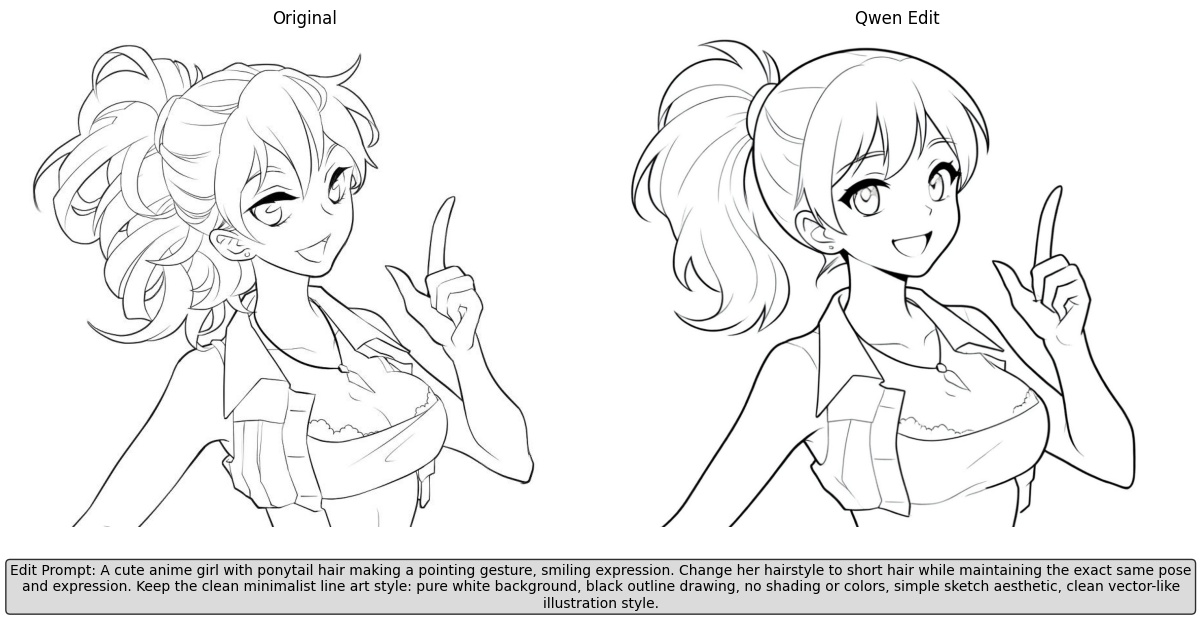

Image saved at /content/drive/MyDrive/SVGEditor/Resource/153_B/IntermediateFiles/153_B_qwen_edit.png
Comparison saved at /content/drive/MyDrive/SVGEditor/Resource/153_B/Comparison/153_B_qwen_comparison.png


In [4]:
from utils import create_comparison_plot

# Edit prompt for the image
EDIT_PROMPT = (
    "A cute anime girl with ponytail hair making a pointing gesture, smiling expression. "
    "Change her hairstyle to short hair while maintaining the exact same pose and expression. "
    "Keep the clean minimalist line art style: pure white background, black outline drawing, "
    "no shading or colors, simple sketch aesthetic, clean vector-like illustration style."
)

# Main processing
pipeline = load_qwen_model()
original_image = load_input_image()
edited_image = process_image_with_qwen(pipeline, original_image, EDIT_PROMPT)

  0%|          | 0/30 [00:00<?, ?it/s]

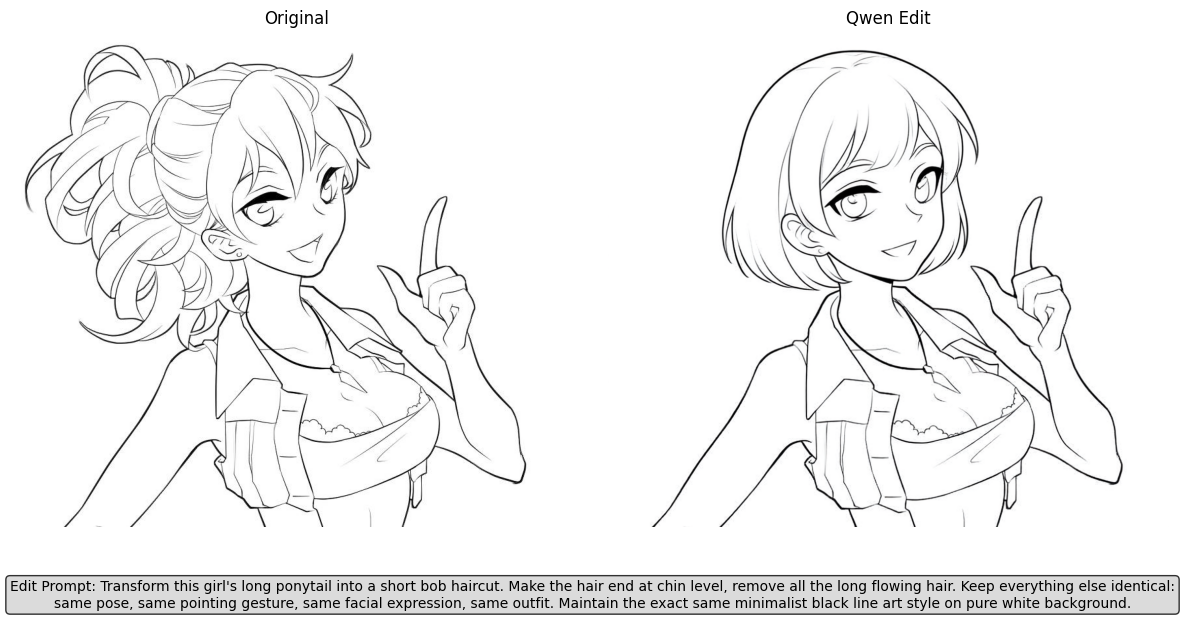

Image saved at /content/drive/MyDrive/SVGEditor/Resource/153_B/IntermediateFiles/153_B_qwen_edit.png
Comparison saved at /content/drive/MyDrive/SVGEditor/Resource/153_B/Comparison/153_B_qwen_comparison.png


In [5]:
# Edit prompt for the image
EDIT_PROMPT = (
    "Transform this girl's long ponytail into a short bob haircut. "
    "Make the hair end at chin level, remove all the long flowing hair. "
    "Keep everything else identical: same pose, same pointing gesture, same facial expression, same outfit. "
    "Maintain the exact same minimalist black line art style on pure white background."
)
edited_image = process_image_with_qwen(pipeline, original_image, EDIT_PROMPT)


In [ ]:
# Cleanup
del pipeline
torch.cuda.empty_cache()
gc.collect()
print("Processing completed")

In [ ]:
import cv2
import numpy as np
from PIL import Image
from skimage import measure
from sklearn.cluster import KMeans
from svglib.svg import SVG, SVGPath
from svglib.geom import Bbox
from sam_processor import process_image_with_sam, get_default_sam_config

def get_dominant_color(pixels, n_colors=5):
    pixels = pixels.reshape(-1, 3)
    n_colors = min(n_colors, len(pixels))
    kmeans = KMeans(n_clusters=n_colors, random_state=42, n_init=10)
    kmeans.fit(pixels)
    colors = kmeans.cluster_centers_.astype(int)
    counts = np.bincount(kmeans.labels_)
    dominant_color = tuple(colors[np.argmax(counts)])
    return dominant_color

def vectorize_masks_to_svg(image: np.ndarray, masks: list) -> SVG:
    sorted_masks = sorted(masks, key=lambda x: x['area'], reverse=True)
    svg_path_groups = []

    for i, mask in enumerate(sorted_masks):
        binary_mask = mask['segmentation'].astype(np.uint8)
        contours = measure.find_contours(binary_mask)

        for smaller_mask in sorted_masks[i+1:]:
            binary_mask = np.logical_and(binary_mask, np.logical_not(smaller_mask['segmentation']))

        binary_mask = binary_mask.astype(np.uint8)
        pixels = image[binary_mask.astype(bool)]

        if len(pixels) > 0:
            color = get_dominant_color(pixels)
            color_hex = '#{:02x}{:02x}{:02x}'.format(*color)

            for contour in contours:
                epsilon = 0.0008 * cv2.arcLength(contour.astype(np.float32), True)
                approx = cv2.approxPolyDP(contour.astype(np.float32), epsilon, True)

                path_data = []
                for j in range(len(approx)):
                    y, x = approx[j][0]
                    if j == 0:
                        path_data.append(f'M {x:.2f} {y:.2f}')
                    else:
                        path_data.append(f'L {x:.2f} {y:.2f}')
                path_data.append('Z')

                svg_path_group = SVGPath.from_str(
                    ' '.join(path_data),
                    fill=True,
                    color=color_hex,
                    add_closing=True,
                )
                svg_path_groups.append(svg_path_group)

    viewbox = Bbox(0, 0, image.shape[1], image.shape[0])
    svg = SVG(svg_path_groups, viewbox=viewbox)
    return svg

def process_target_vectorization(target_name):
    image_path = f"{RESOURCE_PATH}/{target_name}/IntermediateFiles/{target_name}_qwen_edit.png"

    sam_config = get_default_sam_config(PROJECT_PATH)
    sam_config.update({
        "points_per_side": 48,
        "pred_iou_thresh": 0.87,
        "stability_score_thresh": 0.95,
        "min_mask_region_area": 30,
    })

    sam_model_path = f"{MODEL_PATH}/sam/sam_vit_h_4b8939.pth"
    masks, image_rgb = process_image_with_sam(
        image_path=image_path,
        sam_config=sam_config,
        model_path=sam_model_path
    )

    intermediate_dir = f"{RESOURCE_PATH}/{target_name}/IntermediateFiles"
    results_dir = f"{RESOURCE_PATH}/{target_name}/Results"
    os.makedirs(intermediate_dir, exist_ok=True)
    os.makedirs(results_dir, exist_ok=True)

    for i, mask in enumerate(masks):
        mask_path = os.path.join(intermediate_dir, f"{target_name}_mask_{i:04d}.png")
        cv2.imwrite(mask_path, mask['segmentation'].astype(np.uint8) * 255)

    svg = vectorize_masks_to_svg(image_rgb, masks)

    svg_raw_path = os.path.join(intermediate_dir, f"{target_name}_raw.svg")
    svg.save_svg(svg_raw_path, coordinate_precision=3)

    svg.line_to_bezier().drop_z().filter_duplicates().filter_consecutives().filter_empty()

    output_svg_path = os.path.join(results_dir, f"{target_name}_final.svg")
    svg.save_svg(output_svg_path, coordinate_precision=3)

def batch_vectorize_targets(target_names):
    for target_name in target_names:
        process_target_vectorization(target_name)

batch_vectorize_targets(TARGET_NAMES)
